In [1]:
# Installation
# !pip install pandas
# !pip install matplotlib
# !pip install tensorflow 
# !pip install nltk
# !pip install scikit-learn

In [38]:
# imports

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import nltk
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
import string

In [3]:
# Check tensorflow version
print(tf.__version__)

2.12.0


# Loading the Data

In [4]:
# Dataset: https://www.kaggle.com/datasets/reihanenamdari/mental-health-corpus

df = pd.read_csv('./mental_health.csv')
df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


# Exploratory Data Analysis

The Mental Health Corpus is a compilation of texts about anxiety, depression, and other mental health problems, labeled as toxic or non-toxic. I intend to use it to train a classifier that is able to make a prediction about a user's mental health status from their social media posts.

## Handling Duplicate Values

In [5]:
df['text'].nunique()

27972

In [6]:
df.shape

(27977, 2)

In [7]:
df['text'].drop_duplicates(inplace = True)

## Class Distributions

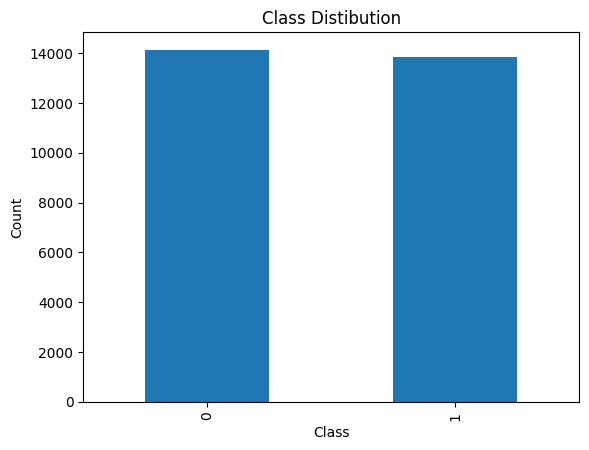

In [8]:
class_counts = df['label'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distibution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

## Data Preprocessing

In [9]:
# check if any entry in 'text' column has any uppercase character
result = any(df['text'].str.contains(r'[A-Z]'))

print(result)

False


In [10]:
# check if there are any URLs in the 'text' column
pattern = r'https?://\S+|www\.\S+'
result = any(df['text'].str.contains(pattern))

print(result)

False


In [11]:
# check if there is any puntuation

# define a set of punctuation characters
punctuation = set(string.punctuation)

# check if any entry in 'text' column has any punctuation character
result = any(set(''.join(df['text'].tolist())).intersection(punctuation))

print(result) # True

True


In [12]:
# removing puntutation

# create a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)

# remove punctuation from 'text' column
df['text'] = df['text'].apply(lambda x: x.translate(translator))

In [13]:
# stemming

# create a stemmer object
stemmer = PorterStemmer()

# stem words in 'text' column
df['text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

df.head()

,text,label
0,dear american teen question dutch person heard...,0
1,noth look forward lifei dont mani reason keep ...,1
2,music recommend im look expand playlist usual ...,0
3,im done tri feel betterth reason im still aliv...,1
4,worri year old girl subject domest physicalmen...,1


# Training a few different Classifiers

## Setting up X and y

In [14]:
# Train test split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [15]:
X_train

10544    hiya leav messag repli wake day took break day...
13576    come friend follow right here anyon know irl s...
27344    artist struggl life sure look formayb convers ...
2001     shoutout unnecessarili strict thing parent som...
22864    set date august th realli feel anyth anymor ti...
                               ...                        
2954                                im good mood final lol
17975    go divorc bankruptci look lose homei bought wa...
26730    think romanc movi help coupl develop deeper ap...
5149     desper femal one interest relationship femal w...
10888    dont get happeningim usual dead insid dont usu...
Name: text, Length: 22381, dtype: object

In [19]:
# Encode text data

# Fit the tokenizer on the training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Encode the training and testing data using the tokenizer
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
maxlen = 100
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

## Sequential Classiffier

In [25]:
# Fit model

model = models.Sequential()
model.add(Embedding(input_dim=10000, output_dim=32, input_length=100))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
560/560 [==============================] - 24s 40ms/step - loss: 0.3562 - accuracy: 0.8551 - val_loss: 0.5498 - val_accuracy: 0.6904
Epoch 2/10
560/560 [==============================] - 23s 41ms/step - loss: 0.4370 - accuracy: 0.8019 - val_loss: 0.4791 - val_accuracy: 0.8678
Epoch 3/10
560/560 [==============================] - 23s 41ms/step - loss: 0.3136 - accuracy: 0.9015 - val_loss: 0.3359 - val_accuracy: 0.8897
Epoch 4/10
560/560 [==============================] - 24s 43ms/step - loss: 0.3155 - accuracy: 0.8987 - val_loss: 0.3296 - val_accuracy: 0.8935
Epoch 5/10
560/560 [==============================] - 24s 42ms/step - loss: 0.3130 - accuracy: 0.8965 - val_loss: 0.3210 - val_accuracy: 0.8955
Epoch 6/10
560/560 [==============================] - 24s 43ms/step - loss: 0.3161 - accuracy: 0.8918 - val_loss: 0.3448 - val_accuracy: 0.8731
Epoch 7/10
560/560 [==============================] - 24s 42ms/step - loss: 0.3265 - accuracy: 0.8885 - val_loss: 0.3159 - val_accuracy:

In [27]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print()
print(classification_report(y_test, y_pred))

175/175 [==============================] - 1s 6ms/step
Test loss: 0.3450027108192444
Test accuracy: 0.8865261077880859

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2828
           1       0.88      0.90      0.89      2768

    accuracy                           0.89      5596
   macro avg       0.89      0.89      0.89      5596
weighted avg       0.89      0.89      0.89      5596



## RNN Classifier

In [31]:
# Define the model architecture
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=32, input_length=maxlen),
    SimpleRNN(units=16),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
280/280 [==============================] - 4s 10ms/step - loss: 0.6031 - accuracy: 0.6700 - val_loss: 0.5931 - val_accuracy: 0.6270
Epoch 2/10
280/280 [==============================] - 3s 10ms/step - loss: 0.3922 - accuracy: 0.8268 - val_loss: 0.2559 - val_accuracy: 0.9102
Epoch 3/10
280/280 [==============================] - 3s 10ms/step - loss: 0.1994 - accuracy: 0.9305 - val_loss: 0.2302 - val_accuracy: 0.9118
Epoch 4/10
280/280 [==============================] - 3s 10ms/step - loss: 0.1342 - accuracy: 0.9556 - val_loss: 0.2399 - val_accuracy: 0.9124
Epoch 5/10
280/280 [==============================] - 3s 10ms/step - loss: 0.1037 - accuracy: 0.9678 - val_loss: 0.2582 - val_accuracy: 0.9071
Epoch 6/10
280/280 [==============================] - 3s 10ms/step - loss: 0.0896 - accuracy: 0.9707 - val_loss: 0.2834 - val_accuracy: 0.9086
Epoch 7/10
280/280 [==============================] - 3s 10ms/step - loss: 0.0701 - accuracy: 0.9786 - val_loss: 0.2886 - val_accuracy: 0.9028

In [32]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print()
print(classification_report(y_test, y_pred))

175/175 [==============================] - 0s 2ms/step
Test loss: 0.34470099210739136
Test accuracy: 0.9013581275939941

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      2828
           1       0.90      0.90      0.90      2768

    accuracy                           0.90      5596
   macro avg       0.90      0.90      0.90      5596
weighted avg       0.90      0.90      0.90      5596



## CNN Classifier

In [35]:
# Build the CNN model
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=maxlen),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
630/630 [==============================] - 5s 7ms/step - loss: 0.2823 - accuracy: 0.8814 - val_loss: 0.2035 - val_accuracy: 0.9209
Epoch 2/10
630/630 [==============================] - 5s 7ms/step - loss: 0.1337 - accuracy: 0.9525 - val_loss: 0.1996 - val_accuracy: 0.9227
Epoch 3/10
630/630 [==============================] - 5s 7ms/step - loss: 0.0603 - accuracy: 0.9818 - val_loss: 0.2384 - val_accuracy: 0.9227
Epoch 4/10
630/630 [==============================] - 5s 7ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.3092 - val_accuracy: 0.9209
Epoch 5/10
630/630 [==============================] - 5s 7ms/step - loss: 0.0084 - accuracy: 0.9979 - val_loss: 0.3521 - val_accuracy: 0.9201
Epoch 6/10
630/630 [==============================] - 5s 7ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.3735 - val_accuracy: 0.9196
Epoch 7/10
630/630 [==============================] - 5s 7ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.4262 - val_accuracy: 0.9236
Epoch 

In [36]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print()
print(classification_report(y_test, y_pred))

175/175 [==============================] - 0s 2ms/step
Test loss: 0.5498153567314148
Test accuracy: 0.9049320816993713

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      2828
           1       0.92      0.89      0.90      2768

    accuracy                           0.90      5596
   macro avg       0.91      0.90      0.90      5596
weighted avg       0.91      0.90      0.90      5596



## CNN with a different embedding approach

Using the GloVe pre-trained embedding that can be found here: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt

In [40]:
# Function to load GloVe embeddings
def load_glove_embeddings(file_path, embedding_dim, word_index):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

# Load GloVe embeddings
glove_file_path = './glove.6B.100d.txt'  # Replace with the path to the GloVe file you want to use
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_file_path, embedding_dim, tokenizer.word_index)

# Build the CNN model
model = models.Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
630/630 [==============================] - 4s 6ms/step - loss: 0.3420 - accuracy: 0.8495 - val_loss: 0.3035 - val_accuracy: 0.8749
Epoch 2/10
630/630 [==============================] - 3s 5ms/step - loss: 0.2298 - accuracy: 0.9088 - val_loss: 0.2621 - val_accuracy: 0.8937
Epoch 3/10
630/630 [==============================] - 3s 5ms/step - loss: 0.1764 - accuracy: 0.9323 - val_loss: 0.2597 - val_accuracy: 0.8924
Epoch 4/10
630/630 [==============================] - 4s 6ms/step - loss: 0.1225 - accuracy: 0.9553 - val_loss: 0.3370 - val_accuracy: 0.8799
Epoch 5/10
630/630 [==============================] - 3s 5ms/step - loss: 0.0849 - accuracy: 0.9694 - val_loss: 0.3622 - val_accuracy: 0.8839
Epoch 6/10
630/630 [==============================] - 3s 5ms/step - loss: 0.0602 - accuracy: 0.9783 - val_loss: 0.3826 - val_accuracy: 0.8883
Epoch 7/10
630/630 [==============================] - 3s 6ms/step - loss: 0.0440 - accuracy: 0.9841 - val_loss: 0.4572 - val_accuracy: 0.8834
Epoch 

In [41]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print()
print(classification_report(y_test, y_pred))

175/175 [==============================] - 0s 2ms/step
Test loss: 0.5829407572746277
Test accuracy: 0.8784846067428589

              precision    recall  f1-score   support

           0       0.91      0.84      0.88      2828
           1       0.85      0.91      0.88      2768

    accuracy                           0.88      5596
   macro avg       0.88      0.88      0.88      5596
weighted avg       0.88      0.88      0.88      5596



## CNN with different embedding approach and added Dropout Layers to mitigate overfitting

In [42]:
# Build the CNN model
model = models.Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Dropout(0.5),  # Dropout layer added after Conv1D layer
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),  # Dropout layer added after Dense layer with 64 units
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
630/630 [==============================] - 5s 7ms/step - loss: 0.4283 - accuracy: 0.8027 - val_loss: 0.3396 - val_accuracy: 0.8700
Epoch 2/10
630/630 [==============================] - 4s 7ms/step - loss: 0.3122 - accuracy: 0.8717 - val_loss: 0.3141 - val_accuracy: 0.8741
Epoch 3/10
630/630 [==============================] - 5s 7ms/step - loss: 0.2845 - accuracy: 0.8832 - val_loss: 0.2856 - val_accuracy: 0.8866
Epoch 4/10
630/630 [==============================] - 5s 7ms/step - loss: 0.2707 - accuracy: 0.8895 - val_loss: 0.2890 - val_accuracy: 0.8883
Epoch 5/10
630/630 [==============================] - 5s 7ms/step - loss: 0.2525 - accuracy: 0.8962 - val_loss: 0.2872 - val_accuracy: 0.8910
Epoch 6/10
630/630 [==============================] - 5s 8ms/step - loss: 0.2401 - accuracy: 0.9068 - val_loss: 0.3179 - val_accuracy: 0.8540
Epoch 7/10
630/630 [==============================] - 5s 7ms/step - loss: 0.2308 - accuracy: 0.9099 - val_loss: 0.2720 - val_accuracy: 0.8848
Epoch 

In [43]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print()
print(classification_report(y_test, y_pred))

175/175 [==============================] - 0s 2ms/step
Test loss: 0.25336122512817383
Test accuracy: 0.8983202576637268

              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2828
           1       0.88      0.92      0.90      2768

    accuracy                           0.90      5596
   macro avg       0.90      0.90      0.90      5596
weighted avg       0.90      0.90      0.90      5596



## CNN with original embedding approach and added Dropout Layers to mitigate overfitting

In [44]:
# Build the CNN model
model = models.Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=maxlen),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Dropout(0.5),  # Dropout layer added after Conv1D layer
    GlobalMaxPooling1D(),
    Dense(units=64, activation='relu'),
    Dropout(0.5),  # Dropout layer added after Dense layer with 64 units
    Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
630/630 [==============================] - 6s 8ms/step - loss: 0.3039 - accuracy: 0.8712 - val_loss: 0.2387 - val_accuracy: 0.9169
Epoch 2/10
630/630 [==============================] - 5s 8ms/step - loss: 0.1666 - accuracy: 0.9390 - val_loss: 0.2312 - val_accuracy: 0.9102
Epoch 3/10
630/630 [==============================] - 5s 8ms/step - loss: 0.1132 - accuracy: 0.9601 - val_loss: 0.2135 - val_accuracy: 0.9125
Epoch 4/10
630/630 [==============================] - 5s 8ms/step - loss: 0.0766 - accuracy: 0.9746 - val_loss: 0.2160 - val_accuracy: 0.9125
Epoch 5/10
630/630 [==============================] - 5s 8ms/step - loss: 0.0510 - accuracy: 0.9834 - val_loss: 0.2248 - val_accuracy: 0.9098
Epoch 6/10
630/630 [==============================] - 5s 8ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.2649 - val_accuracy: 0.9075
Epoch 7/10
630/630 [==============================] - 5s 8ms/step - loss: 0.0265 - accuracy: 0.9910 - val_loss: 0.3139 - val_accuracy: 0.8995
Epoch 

In [45]:
# Evaluate the model

loss, accuracy = model.evaluate(X_test, y_test)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('Test loss:', loss)
print('Test accuracy:', accuracy)
print()
print(classification_report(y_test, y_pred))

175/175 [==============================] - 0s 2ms/step
Test loss: 0.3798658847808838
Test accuracy: 0.8943888545036316

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2828
           1       0.86      0.95      0.90      2768

    accuracy                           0.89      5596
   macro avg       0.90      0.89      0.89      5596
weighted avg       0.90      0.89      0.89      5596

